# Classic Risk Premia Portfolio Backtest

In this notebook we backtest a classic long-only portfolio of ETFs.

Profits are re-invested.

Rebalancing occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the buffer limit only is considered optimal.

In [9]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola


In [10]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'], start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046669,50.798893,44.380001
2004-11-19,40.548492,50.393513,44.779999
2004-11-22,40.815380,50.656151,44.950001
2004-11-23,40.829613,50.719013,44.750000
2004-11-24,41.064484,50.719013,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


In [11]:
weight_df = price_df.copy()
weight_df[:] = [0.333, 0.333, 0.333]
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,0.333,0.333,0.333
2004-11-19,0.333,0.333,0.333
2004-11-22,0.333,0.333,0.333
2004-11-23,0.333,0.333,0.333
2004-11-24,0.333,0.333,0.333
...,...,...,...
2022-10-03,0.333,0.333,0.333
2022-10-04,0.333,0.333,0.333
2022-10-05,0.333,0.333,0.333


In [12]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-18 VTI       41.046669         0.000000      0.000000        0.000000   
           TLT       50.798893         0.000000      0.000000        0.000000   
           GLD       44.380001         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2004-11-19 VTI       40.548492        81.127168   3289.584345        0.331177   
...                        ...              ...           ...             ...   
2022-10-06 cash       1.000000       150.266218    150.266218        0.004075   
2022-10-07 VTI      182.399994        65.220791  11896.271884        0.327987   
           TLT      100.989998       119.864512  12105.116765        0.333745   
           GLD      157.880005        76.760168  12118.895713        0.334125   
           cash       1.000000       150.266218    150.266218        0.004143   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2004-11-18 VTI              0.333      0.333000      True           0.333000   
           TLT              0.333      0.333000      True           0.333000   
           GLD              0.333      0.333000      True           0.333000   
           cash             0.001     -0.999000     False           1.000000   
2004-11-19 VTI              0.333      0.001823     False           0.331177   
...                           ...           ...       ...                ...   
2022-10-06 cash             0.001     -0.003075     False           0.004075   
2022-10-07 VTI              0.333      0.005013     False           0.327987   
           TLT              0.333     -0.000745     False           0.333745   
           GLD              0.333     -0.001125     False           0.334125   
           cash             0.001     -0.003143     False           0.004143   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2004-11-18 VTI                 0.333       3330.0   81.127168        10.0   
           TLT                 0.333       3330.0   65.552610        10.0   
           GLD                 0.333       3330.0   75.033797        10.0   
           cash                0.000          0.0    0.000000         0.0   
2004-11-19 VTI                 0.000          0.0    0.000000         0.0   
...                              ...          ...         ...         ...   
2022-10-06 cash                0.000          0.0    0.000000         0.0   
2022-10-07 VTI                 0.000          0.0    0.000000         0.0   
           TLT                 0.000          0.0    0.000000         0.0   
           GLD                 0.000          0.0    0.000000         0.0   
           cash                0.000          0.0    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2004-11-18 VTI          81.127168  
           TLT          65.552610  
           GLD          75.033797  
           cash        -20.000000  
2004-11-19 VTI          81.127168  
...                           ...  
2022-10-06 cash        150.266218  
2022-10-07 VTI          65.220791  
           TLT         119.864512  
           GLD          76.760168  
           cash        150.266218  

[18012 rows x 13 columns]

In [13]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df.tail(5))

64

,,price,start_portfolio,equity,current_weight,target_weight,delta_weight,do_trade,adj_target_weight,adj_delta_weight,trade_value,trade_size,commission,end_portfolio
datetime,Symbols,,,,,,,,,,,,,
2021-03-17,TLT,131.428268,91.559911,12033.560535,0.291594,0.333,0.041406,True,0.333,0.041406,1708.773207,13.001565,10.0,104.561476
2021-03-30,GLD,157.570007,75.338177,11871.037056,0.291577,0.333,0.041423,True,0.333,0.041423,1686.442148,10.702812,10.0,86.040989
2021-08-09,VTI,224.683838,73.182647,16442.958004,0.373651,0.333,-0.040651,True,0.333,-0.040651,-1788.900367,-7.961856,10.0,65.220791
2022-04-14,TLT,119.337334,104.561476,12478.087757,0.290486,0.333,0.042514,True,0.333,0.042514,1826.223454,15.303036,10.0,119.864512
2022-05-06,GLD,175.419998,86.040989,15093.310063,0.373262,0.333,-0.040262,True,0.333,-0.040262,-1628.041516,-9.280821,10.0,76.760168


In [14]:
stats = calc_stats(result)
display(stats)

,equity
start,2004-11-18 00:00:00
end,2022-10-07 00:00:00
rf,0.0
total_return,2.627055
cagr,0.074703
max_drawdown,-0.22608
calmar,0.330428
mtd,0.008109
three_month,-0.065344
six_month,-0.166884


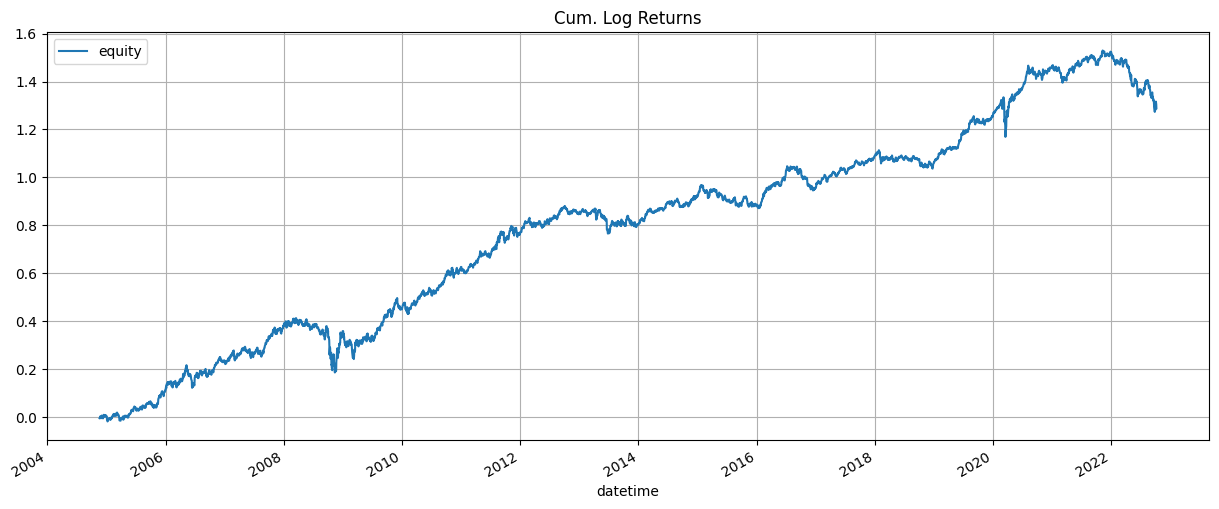

In [15]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

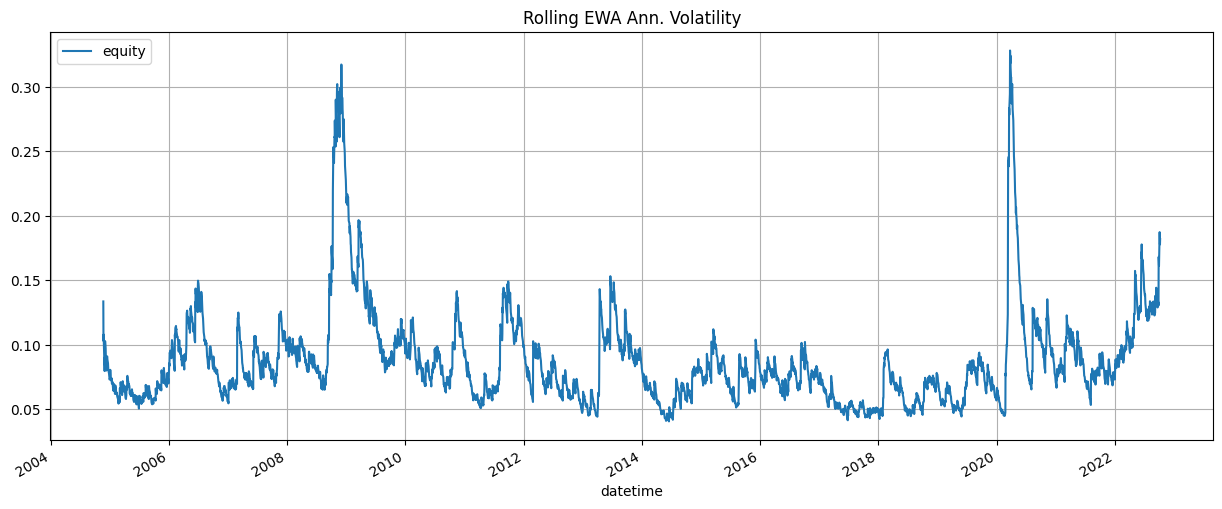

In [16]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()